# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

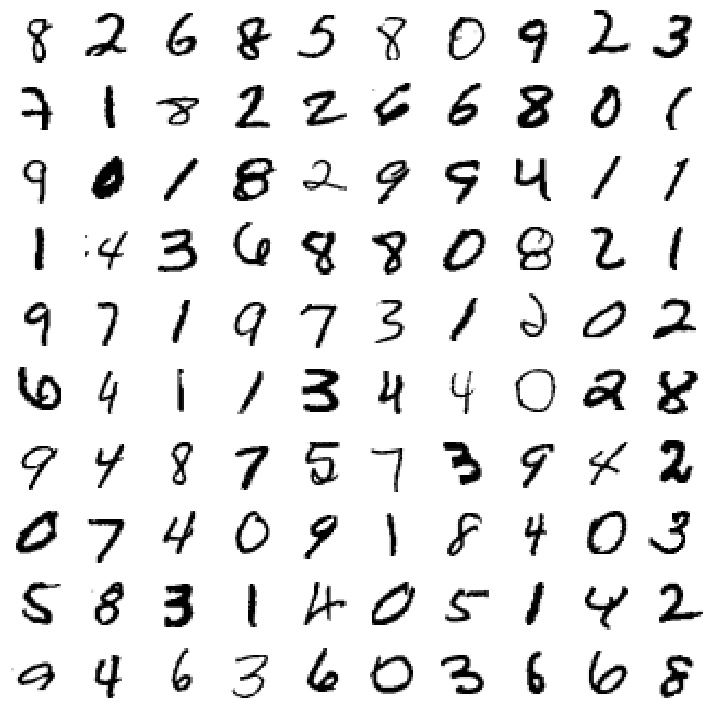

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: &quot;sequential_6&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)    

Compile and train the network (note that this could take a while).

In [34]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 [==============================] - 73s 156ms/step - loss: 0.2302 - accuracy: 0.9308 - val_loss: 0.0571 - val_accuracy: 0.9816
Epoch 2/12
469/469 [==============================] - 74s 158ms/step - loss: 0.0853 - accuracy: 0.9748 - val_loss: 0.0386 - val_accuracy: 0.9878
Epoch 3/12
469/469 [==============================] - 73s 156ms/step - loss: 0.0621 - accuracy: 0.9811 - val_loss: 0.0309 - val_accuracy: 0.9890
Epoch 4/12
469/469 [==============================] - 74s 157ms/step - loss: 0.0500 - accuracy: 0.9846 - val_loss: 0.0312 - val_accuracy: 0.9903
Epoch 5/12
469/469 [==============================] - 75s 161ms/step - loss: 0.0450 - accuracy: 0.9857 - val_loss: 0.0291 - val_accuracy: 0.9905
Epoch 6/12
469/469 [==============================] - 75s 161ms/step - loss: 0.0362 - accuracy: 0.9890 - val_loss: 0.0278 - val_accuracy: 0.9925
Epoch 7/12
469/469 [==============================] - 76s 161ms/step - loss: 0.0331 - accuracy: 0.9894 - val_loss: 0.0293 - val_ac

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [4]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04835459589958191
Test accuracy: 0.984000027179718


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


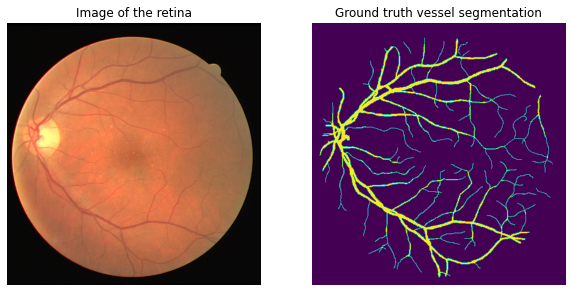

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import sys
sys.path.append('code/')
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = "C:/Users/20175722/Documents/Master jaar 1/Kwartiel 1/8DM50 - Machine learning/DRIVE/"
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


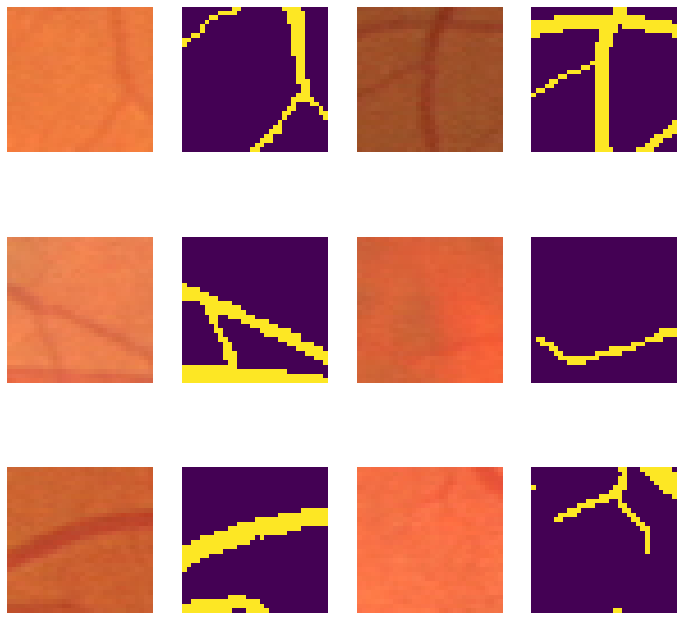

In [8]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [9]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [12]:
import os
from unet_model import unet
from unet_utils import datagenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/10
50/50 - 54s - loss: 0.5460 - accuracy: 0.7869 - val_loss: 0.4163 - val_accuracy: 0.9211
Epoch 2/10
50/50 - 56s - loss: 0.3391 - accuracy: 0.9456 - val_loss: 0.5663 - val_accuracy: 0.7099
Epoch 3/10
50/50 - 52s - loss: 0.2305 - accuracy: 0.9599 - val_loss: 0.2622 - val_accuracy: 0.9211
Epoch 4/10
50/50 - 70s - loss: 0.2070 - accuracy: 0.9533 - val_loss: 0.2714 - val_accuracy: 0.9208
Epoch 5/10
50/50 - 72s - loss: 0.1648 - accuracy: 0.9579 - val_loss: 0.2683 - val_accuracy: 0.9211
Epoch 6/10
50/50 - 62s - loss: 0.1398 - accuracy: 0.9588 - val_loss: 0.2681 - val_accuracy: 0.9208
Epoch 7/10
50/50 - 60s - loss: 0.1312 - accuracy: 0.9606 - val_loss: 0.2994 - val_accuracy: 0.9214
Epoch 8/10
50/50 - 52s - loss: 0.1285 - accuracy: 0.9607 - val_loss: 0.2659 - val_accuracy: 0.9269
Epoch 9/10
50/50 - 48s - loss: 0.1172 - accuracy: 0.9621 - val_loss: 0.2733 - val_accuracy: 0.9270
Epoch 10/10
50/50 - 49s - loss: 0.1111 - accuracy: 0.9625 - val_loss: 0.212

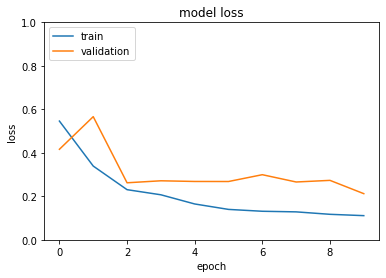

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Visualizing the segmentation results

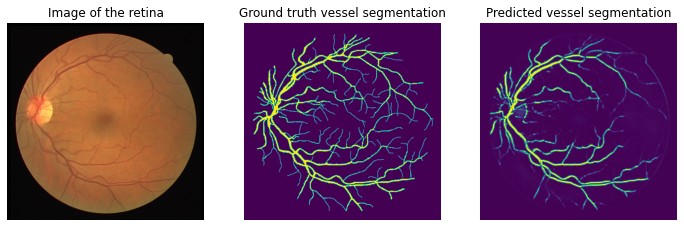

In [14]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

***Answer***: The parameters correspond to the weights of the connections.

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

***Answer***:  In a convolutional layer the number of parameters equals: $$p =  (k_x \cdot k_y \cdot f + 1 ) \cdot g $$

 With convolutional kernel $k = (k_x, k_y)$, and number of filters $f$ in the previous layer and $g$ in the current layer.

 For a fully connected layer:

 $$ p = (c \cdot p)+c $$

 With $c$ the number of neurons in the current layer and $p$ the number of neurons in the previous layer.

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

***Answer***: The test loss (0.02) and test accuracy (0.992) are for both models approximately the same. 

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

***Answer***: Because of down-sampling, detailed information on local features get lost in the network. By using skip connections, these details can be preserved when upsampling for prediction. When omitting the skip connections, the network could be trained, but not meaningfully, as most localization information is absent.   

## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>

***Answer***: It gives less overfitting, because you can train the model with more variated data. As your final evaluation is done on your test set, containing 'real-life' data, there would be no need for augmentation, as it would only deviate your final model accuracy measure from the 'true value'. Nevertheless, in some specific cases it could be usefull. For instance, when augmentation involves cropping images to some kind of desired shape, this must be applied to the test set as well before any model predictions can be made, due to the requirements of the neural network. It can also be applied to see if your model is robust. You could rotate an image of a 5 to show that the model can still predict it well when the 5 is upside down.     


Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above.

***Answer***: The validation accuracy varies a lot more. This might be because the augmentation is too extreme, making the model worse. Especially since no data augmentation is applied to the validation set.

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

***Answer***: Same as the only-brightness augmentation, the validation accuracy has drops in some epochs. These are even steeper than the only-brightness augmentation, indicating that not only the brightness augmentation, but also the b-spline are too extreme. However, this model eventually has a slightly higher validation accuracy. 

**Answer**: We applied augmentation within the datagenerator. Training on one image without augmentation gives more overfitting, as can be seen from the training-validation loss curve above, where the validation loss does not follow along completely with the training loss. When applying brightness augmentation, the loss curve shows that the validation loss follows the training loss, which indicates less overfitting. This is also the case, where b-spline augmentation is added to the brightness augmentation, where the validation loss follows the training loss the best of all three.


In [19]:
# Fully connected MNIST model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Reshape((1,9216)))
model.add(Conv1D(128, (1), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(10, (1), activation='softmax'))
model.add(Flatten())

model.summary()

#Reload MNIST data
# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)



# Determine test loss and accuracy
model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

print(X_test.shape)
print(y_test.shape)
model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test) )

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: &quot;sequential_5&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 9216)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 128)            1179776   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 128) 

In [ ]:
#score = model.evaluate(x_test, y_test, verbose=0)

#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

In [27]:
# Random brightness
import os
import sys
import numpy as np
sys.path.append('code/')
from unet_model import unet
from unet_utils import datagenerator, load_data, preprocessing
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob


# location of the DRIVE dataset
#data_folder = 'D:/TUe/MY1/8dm50-machine-learning/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))



val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size, augment_brightness=True, augment_bspline=False),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss using brightness')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/5


KeyboardInterrupt: 

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/5
50/50 - 54s - loss: 0.6099 - accuracy: 0.7244 - val_loss: 0.4666 - val_accuracy: 0.9211
Epoch 2/5
50/50 - 49s - loss: 0.3950 - accuracy: 0.9238 - val_loss: 1.2689 - val_accuracy: 0.1695
Epoch 3/5
50/50 - 46s - loss: 0.2952 - accuracy: 0.9385 - val_loss: 0.2712 - val_accuracy: 0.9209
Epoch 4/5
50/50 - 45s - loss: 0.2319 - accuracy: 0.9465 - val_loss: 0.2767 - val_accuracy: 0.9197
Epoch 5/5
50/50 - 46s - loss: 0.1998 - accuracy: 0.9471 - val_loss: 0.3076 - val_accuracy: 0.9204


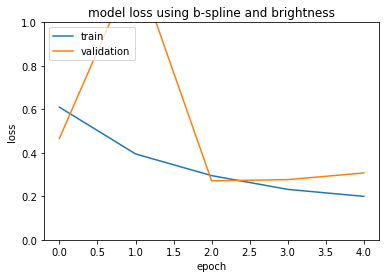

In [30]:
# Data augmentation B-spline and brightness
import os
import sys
import numpy as np
sys.path.append('code/')
from unet_model import unet
from unet_utils import datagenerator, load_data, preprocessing
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob


# location of the DRIVE dataset
#data_folder = 'D:/TUe/MY1/8dm50-machine-learning/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))



val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size, augment_brightness=True, augment_bspline=True),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss using b-spline and brightness')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(0,1)
plt.show()